In [1]:
%%file tauchen.m
function [Z,Zprob] = tauchen(N,mu,rho,sigma,m)

Z     = zeros(N,1); % グリッド
Zprob = zeros(N,N); % 遷移確率の行列
c     = (1-rho)*mu; % 定数項

% 等間隔のグリッドを定める
% 最大値と最小値
zmax  = m*sqrt(sigma^2/(1-rho^2));
zmin  = -zmax;
% グリッド間の間隔
w = (zmax-zmin)/(N-1);

Z = linspace(zmin,zmax,N)';
% 定常状態はmu
Z = Z + mu;

% グリッドを所与として、遷移確率を求める
for j = 1:N
    for k = 1:N
        if k == 1
            Zprob(j,k) = cdf_normal((Z(1)-c-rho*Z(j)+w/2)/sigma);
        elseif k == N
            Zprob(j,k) = 1 - cdf_normal((Z(N)-c-rho*Z(j)-w/2)/sigma);
        else
            Zprob(j,k) = cdf_normal((Z(k)-c-rho*Z(j)+w/2)/sigma) - ...
                         cdf_normal((Z(k)-c-rho*Z(j)-w/2)/sigma);
        end
    end
end

% 正規分布の累積分布関数
function c = cdf_normal(x)
    c = 0.5*erfc(-x/sqrt(2));

Created file 'C:\Users\takeki\Documents\keizai-seminar\chapter5\Matlab\2_NstateNK\tauchen.m'.


In [2]:
%%file ti.m
function [yvec0 pvec0 rvec0 Gg Gu] = ti(m)

% disp('')
% disp('-+- Solve a two-state model with time iteration -+-');

%% STEP 1(a): グリッド生成
[Gg Pg] = tauchen(m.Ng,m.sig*m.rstar,m.rhog,m.sigg,3.0);
[Gu Pu] = tauchen(m.Nu,0,m.rhou,m.sigu,3.0);

Ns = m.Ng*m.Nu;
Gs = zeros(Ns,2);

for ig = 1:m.Ng
    
    for iu = 1:m.Nu
        
        Gs(m.Nu*(ig-1)+iu,1) = Gg(ig);
        Gs(m.Nu*(ig-1)+iu,2) = Gu(iu);
        
    end
    
end

Ps = kron(Pg,Pu);

%% STEP 1(b): 政策関数の初期値を当て推量
% 適当な初期値
yvec0 = zeros(Ns,1);
pvec0 = zeros(Ns,1);
rvec0 = zeros(Ns,1);
yvec1 = zeros(Ns,1);
pvec1 = zeros(Ns,1);
rvec1 = zeros(Ns,1);

%% STEP 4: 政策関数を繰り返し計算
diff = 1e+4; % 政策関数の繰り返し誤差
iter = 1; % ループ・カウンター

while(diff > m.tol)

    for is = 1:Ns

        % ショックの値
        g0 = Gs(is,1);
        u0 = Gs(is,2);

        % 古い政策関数から期待値(ye, pie)を計算
        ye = Ps(is,:)*yvec0;
        pie = Ps(is,:)*pvec0;

        % 期待値を所与として最適化
        p0 = (m.bet*pie+u0)/(1+m.kap^2/m.lam);
        y0 = (-m.kap/m.lam)*p0;
        r0 = (1/m.sig)*(ye - y0 + g0) + pie;

        if (r0<0)
            y0 = ye - m.sig*(0 - pie) + g0;
            p0 = m.kap*y0 + m.bet*pie + u0;
            r0 = 0;
        end

        % 新しい政策関数を保存
        yvec1(is,1) = y0;
        pvec1(is,1) = p0;
        rvec1(is,1) = r0;

    end
    
    % 繰り返し計算誤差を確認
    ydiff = max(abs(yvec1-yvec0));
    pdiff = max(abs(pvec1-pvec0));
    rdiff = max(abs(rvec1-rvec0));
    diff = max([ydiff pdiff rdiff]);

    disp([iter diff]);

    % 政策関数をアップデート
    yvec0 = yvec1;
    pvec0 = pvec1;
    rvec0 = rvec1;
    
    iter = iter + 1;
    
end

Created file 'C:\Users\takeki\Documents\keizai-seminar\chapter5\Matlab\2_NstateNK\ti.m'.


In [3]:
m.rstar = 3.5/4; % pH=0のときの、定常状態での名目金利の値
m.bet = 1/(1+m.rstar/100); % 割引率(オイラー方程式の定常状態より)
m.sig = 6.25;
m.alp = 0.66;
m.the = 7.66;
m.ome = 0.47;
m.kap = (1-m.alp)*(1-m.alp*m.bet)/m.alp*(1/m.sig+m.ome)/(1+m.ome*m.the); %0.024;
m.lam = 0.048/16; %0.003;

% joint shock process
m.rhou = 0;
m.rhog = 0.8;
m.sigu = 0.154;
m.sigg = 1.524;
m.Ng = 31;
m.Nu = 31;

m.maxiter = 2000; % 繰り返し回数の最大値
m.tol = 1e-5; % 許容誤差

m


m = 

  フィールドをもつ struct:

      rstar: 0.8750
        bet: 0.9913
        sig: 6.2500
        alp: 0.6600
        the: 7.6600
        ome: 0.4700
        kap: 0.0244
        lam: 0.0030
       rhou: 0
       rhog: 0.8000
       sigu: 0.1540
       sigg: 1.5240
         Ng: 31
         Nu: 31
    maxiter: 2000
        tol: 1.0000e-05




In [4]:
tic;
[yvec0 pvec0 rvec0 Gg Gu] = ti(m);
toc;

    1.0000    3.1346

    2.0000    1.1185

    3.0000    0.6430

    4.0000    0.4170

    5.0000    0.2935

    6.0000    0.2182

    7.0000    0.1682

    8.0000    0.1331

    9.0000    0.1069

   10.0000    0.0871

   11.0000    0.0719

   12.0000    0.0599

   13.0000    0.0501

   14.0000    0.0421

   15.0000    0.0355

   16.0000    0.0300

   17.0000    0.0254

   18.0000    0.0216

   19.0000    0.0184

   20.0000    0.0158

   21.0000    0.0136

   22.0000    0.0117

   23.0000    0.0101

   24.0000    0.0087

   25.0000    0.0075

   26.0000    0.0065

   27.0000    0.0056

   28.0000    0.0049

   29.0000    0.0042

   30.0000    0.0037

   31.0000    0.0032

   32.0000    0.0028

   33.0000    0.0025

   34.0000    0.0021

   35.0000    0.0019

   36.0000    0.0016

   37.0000    0.0014

   38.0000    0.0012

   39.0000    0.0011

   40.0000    0.0009

   41.0000    0.0008

   42.0000    0.0007

   43.0000    0.0006

   44.0000    0.0005

   45.0000    0.0005

   46.0000

In [5]:
% replicate Figures 4-5 in the paper
for ig = 1:m.Ng
    
    for iu = 1:m.Nu
        
        ymat0(ig,iu) = yvec0(m.Nu*(ig-1)+iu,1);
        pmat0(ig,iu) = pvec0(m.Nu*(ig-1)+iu,1);
        rmat0(ig,iu) = rvec0(m.Nu*(ig-1)+iu,1);
        
    end
    
end

rmat0 = rmat0; %-rstar;
Gg = Gg; %-sig*rstar;
idu = ceil(m.Nu/2);
stg = 1;
edg = ceil(m.Ng/2);

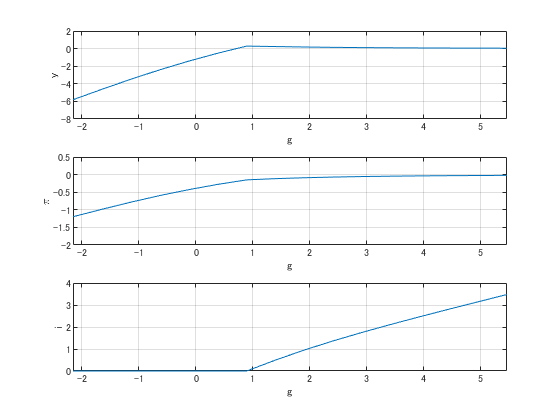

In [6]:
figure;
subplot(311);
plot(Gg(stg:edg),ymat0(stg:edg,idu));
xlim([Gg(stg) Gg(edg)]);
ylim([-8 2]); yticks([-8:2:2]);
grid on;
xlabel('g'); ylabel('y');
subplot(312);
plot(Gg(stg:edg),4*pmat0(stg:edg,idu));
xlim([Gg(stg) Gg(edg)]);
ylim([-2 0.5]); yticks([-2:0.5:0.5]);
grid on;
xlabel('g'); ylabel('\pi');
subplot(313);
plot(Gg(stg:edg),4*rmat0(stg:edg,idu));
xlim([Gg(stg) Gg(edg)]);
%ylim([-4 0]); yticks([-4:1:0]);
grid on;
xlabel('g'); ylabel('i');